In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix, precision_score, plot_roc_curve, auc

#import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
sns.set()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mti-dac-mincomp/SampleSubmission.csv
/kaggle/input/mti-dac-mincomp/train.csv
/kaggle/input/mti-dac-mincomp/test.csv


# Importing Data

In [2]:
train = pd.read_csv('/kaggle/input/mti-dac-mincomp/train.csv')
test = pd.read_csv('/kaggle/input/mti-dac-mincomp/test.csv')

In [3]:
# Preview dataset
train.head()

,employee_id,umur,jenis_kelamin,IPK,level,tahun_lulus,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji,resign
0,10000,NaN,Laki-laki,1.947303,Junior,NaN,Sudah Menikah,management,210.0,0.82,0.419035,3,3 Years,belum pernah,belum,sedang,0
1,10001,NaN,Laki-laki,3.218346,Full-Time,NaN,Belum Menikah,sales,189.0,0.76,0.558254,3,24 Months,belum pernah,belum,rendah,0
2,10002,NaN,Laki-laki,2.117364,Senior,NaN,Sudah Menikah,management,NaN,0.81,0.580364,5,2 Years,pernah,belum,tinggi,0
3,10003,NaN,Laki-laki,3.178748,Full-Time,NaN,Belum Menikah,sales,121.0,0.84,0.446109,3,36 Months,pernah,belum,rendah,0
4,10004,34.0,Laki-laki,2.680535,Part-Time,2008.0,Belum Menikah,technical,229.0,0.48,NaN,3,3 Years,belum pernah,belum,rendah,0


## Initial Screening

In [4]:
train.shape

(10049, 17)

In [5]:
# Describe numeric columns
train.describe()

,employee_id,umur,IPK,tahun_lulus,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,resign
count,10049.000000,2338.000000,10049.000000,2338.000000,8700.000000,9253.000000,8499.000000,10049.000000,10049.000000
mean,15024.000000,33.499572,2.396161,2008.151839,202.981379,0.611906,0.455847,3.797691,0.238034
std,2901.040762,7.951891,0.868485,7.988843,56.708467,0.247945,0.113812,1.227331,0.425901
min,10000.000000,20.000000,0.003057,1986.000000,96.000000,0.090000,0.000000,2.000000,0.000000
25%,12512.000000,27.000000,1.778721,2003.000000,156.000000,0.440000,0.382326,3.000000,0.000000
50%,15024.000000,32.000000,2.523730,2009.000000,200.000000,0.640000,0.448720,4.000000,0.000000
75%,17536.000000,39.000000,3.091618,2015.000000,246.000000,0.810000,0.522630,5.000000,0.000000
max,20048.000000,55.000000,3.989568,2024.000000,559.000000,1.000000,1.000000,7.000000,1.000000


In [6]:
# Column data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10049 entries, 0 to 10048
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   employee_id                    10049 non-null  int64  
 1   umur                           2338 non-null   float64
 2   jenis_kelamin                  10049 non-null  object 
 3   IPK                            10049 non-null  float64
 4   level                          10049 non-null  object 
 5   tahun_lulus                    2338 non-null   float64
 6   status_perkawinan              10049 non-null  object 
 7   divisi                         10049 non-null  object 
 8   rerata_jam_bulanan             8700 non-null   float64
 9   tingkat_kepuasan_bekerja       9253 non-null   float64
 10  nilai_evaluasi_terakhir        8499 non-null   float64
 11  jumlah_proyek_yang_dikerjakan  10049 non-null  int64  
 12  lama_di_perusahaan             10049 non-null 

In [7]:
# Missing values per column

train.isna().sum()

# train.isna().sum()/len(train)

employee_id                         0
umur                             7711
jenis_kelamin                       0
IPK                                 0
level                               0
tahun_lulus                      7711
status_perkawinan                   0
divisi                              0
rerata_jam_bulanan               1349
tingkat_kepuasan_bekerja          796
nilai_evaluasi_terakhir          1550
jumlah_proyek_yang_dikerjakan       0
lama_di_perusahaan                  0
kecelakaan_kerja                    0
promosi_5thn_lalu                   0
tingkat_gaji                        0
resign                              0
dtype: int64

In [8]:
# Missing values per column

test.isna().sum()

# test.isna().sum()/len(test)

employee_id                         0
umur                             3880
jenis_kelamin                       0
IPK                                 0
level                               0
tahun_lulus                      3799
status_perkawinan                   0
divisi                              0
rerata_jam_bulanan                588
tingkat_kepuasan_bekerja          466
nilai_evaluasi_terakhir           856
jumlah_proyek_yang_dikerjakan       0
lama_di_perusahaan                  0
kecelakaan_kerja                    0
promosi_5thn_lalu                   0
tingkat_gaji                        0
dtype: int64

In [9]:
# Check for duplicate values
train.duplicated().any()

False

In [10]:
# Label proportion
train['resign'].value_counts()

0    7657
1    2392
Name: resign, dtype: int64

# Exploratory Data Analysis

## Numeric Features

In [11]:
train.head()

,employee_id,umur,jenis_kelamin,IPK,level,tahun_lulus,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji,resign
0,10000,NaN,Laki-laki,1.947303,Junior,NaN,Sudah Menikah,management,210.0,0.82,0.419035,3,3 Years,belum pernah,belum,sedang,0
1,10001,NaN,Laki-laki,3.218346,Full-Time,NaN,Belum Menikah,sales,189.0,0.76,0.558254,3,24 Months,belum pernah,belum,rendah,0
2,10002,NaN,Laki-laki,2.117364,Senior,NaN,Sudah Menikah,management,NaN,0.81,0.580364,5,2 Years,pernah,belum,tinggi,0
3,10003,NaN,Laki-laki,3.178748,Full-Time,NaN,Belum Menikah,sales,121.0,0.84,0.446109,3,36 Months,pernah,belum,rendah,0
4,10004,34.0,Laki-laki,2.680535,Part-Time,2008.0,Belum Menikah,technical,229.0,0.48,NaN,3,3 Years,belum pernah,belum,rendah,0


In [12]:
numeric_cols = ['umur','IPK','rerata_jam_bulanan', 'tingkat_kepuasan_bekerja', 'nilai_evaluasi_terakhir']

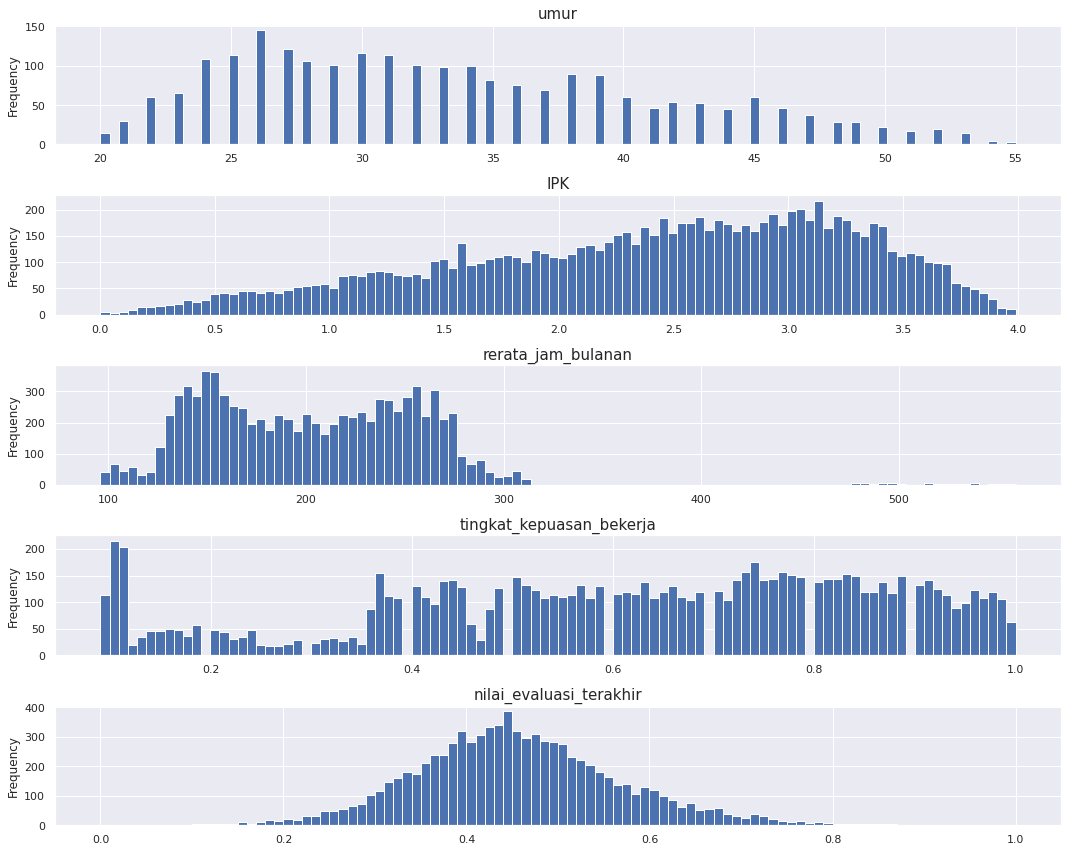

In [13]:
# Plot all hist
f, axes = plt.subplots(5, 1, figsize=(15,3*4))

for ax,col in zip(axes.flatten(), numeric_cols):
    train[col].plot(kind='hist', ax=ax, bins=100) #yg penting cuma bagian ini
    ax.set_title(col, fontsize=15)
    
f.tight_layout()

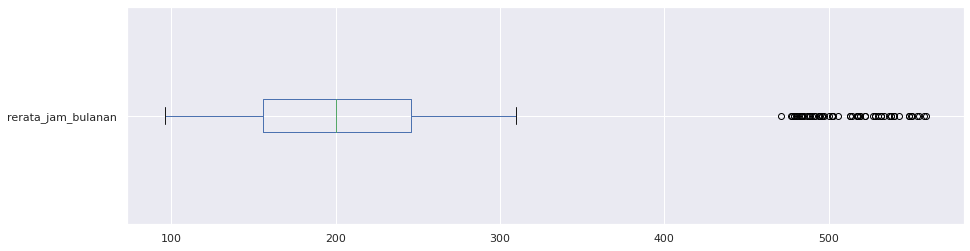

In [14]:
# Box plot
plt.figure(figsize=(15,4))
train['rerata_jam_bulanan'].plot(kind='box', vert=False)

plt.show()

<Figure size 720x720 with 0 Axes>

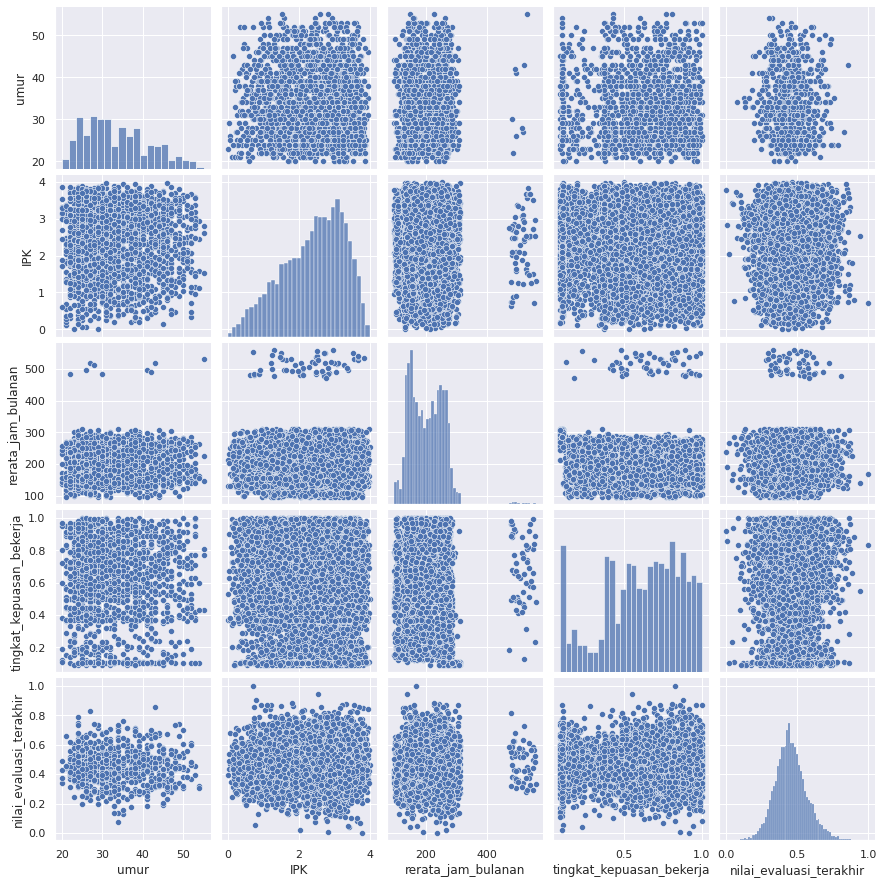

In [15]:
f = plt.figure(figsize=(10,10))
sns.pairplot(train[numeric_cols])

## Categorical Features

In [16]:
train.columns

Index(['employee_id', 'umur', 'jenis_kelamin', 'IPK', 'level', 'tahun_lulus',
       'status_perkawinan', 'divisi', 'rerata_jam_bulanan',
       'tingkat_kepuasan_bekerja', 'nilai_evaluasi_terakhir',
       'jumlah_proyek_yang_dikerjakan', 'lama_di_perusahaan',
       'kecelakaan_kerja', 'promosi_5thn_lalu', 'tingkat_gaji', 'resign'],
      dtype='object')

In [17]:
train.head()

,employee_id,umur,jenis_kelamin,IPK,level,tahun_lulus,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji,resign
0,10000,NaN,Laki-laki,1.947303,Junior,NaN,Sudah Menikah,management,210.0,0.82,0.419035,3,3 Years,belum pernah,belum,sedang,0
1,10001,NaN,Laki-laki,3.218346,Full-Time,NaN,Belum Menikah,sales,189.0,0.76,0.558254,3,24 Months,belum pernah,belum,rendah,0
2,10002,NaN,Laki-laki,2.117364,Senior,NaN,Sudah Menikah,management,NaN,0.81,0.580364,5,2 Years,pernah,belum,tinggi,0
3,10003,NaN,Laki-laki,3.178748,Full-Time,NaN,Belum Menikah,sales,121.0,0.84,0.446109,3,36 Months,pernah,belum,rendah,0
4,10004,34.0,Laki-laki,2.680535,Part-Time,2008.0,Belum Menikah,technical,229.0,0.48,NaN,3,3 Years,belum pernah,belum,rendah,0


In [18]:
train['lama_di_perusahaan']=  train['lama_di_perusahaan'].str.replace("Years", '*12').str.replace('Months','*1').apply(eval).astype(str) + ' Months'

In [19]:
categorical_cols = ['jenis_kelamin', 'level', 'jumlah_proyek_yang_dikerjakan', 'status_perkawinan', 'divisi', 'kecelakaan_kerja', 'promosi_5thn_lalu', 'tingkat_gaji', 'lama_di_perusahaan','tahun_lulus']

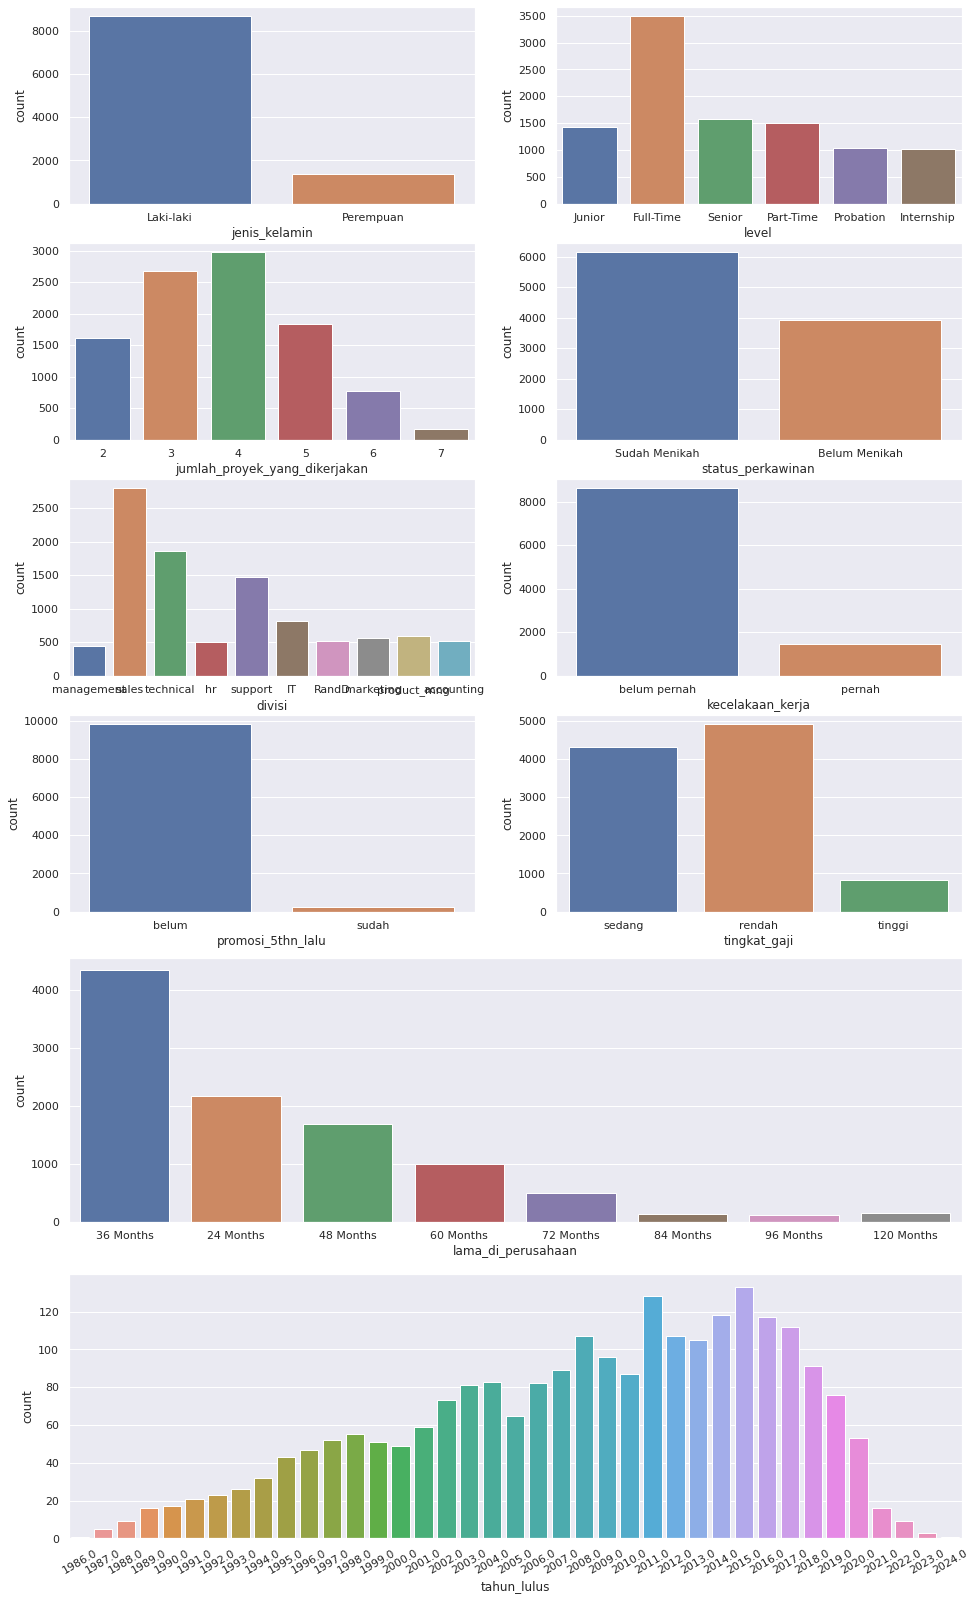

In [20]:
# Plot all Categorical Cols
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16)) = plt.subplots(8,2,figsize=(16,34))

ax9.remove()
ax10.remove()
ax11.remove()
ax12.remove()
ax13.remove()
ax14.remove()
ax15.remove()
ax16.remove()

ax9 = fig.add_subplot(614)
ax11 = fig.add_subplot(615)

for ax,col in zip(fig.axes, categorical_cols):
    sns.countplot(x=train[col], ax=ax)

#ax6.tick_params('x', rotation=20)
ax11.tick_params('x', rotation=30)
    
f.tight_layout()

## Cross Tabulation w.r.t Target

In [21]:
ctab = pd.crosstab(train['level'], train['resign'])
ctab

resign,0,1
level,,
Full-Time,2642,846
Internship,775,244
Junior,1068,360
Part-Time,1152,357
Probation,819,215
Senior,1201,370


<AxesSubplot:xlabel='level'>

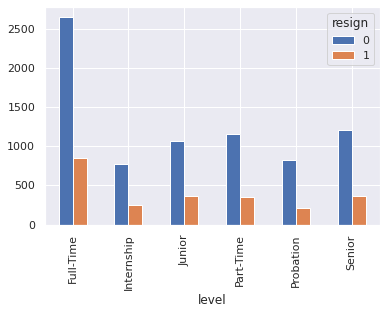

In [22]:
ctab.plot(kind='bar')

## Proportion of Labels

Text(0.5, 1.0, 'Resign Proportion')

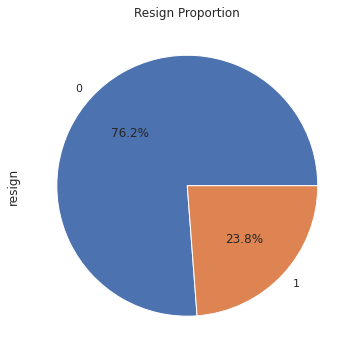

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
train['resign'].value_counts(normalize=True).plot(ax=ax1, kind='pie',autopct="%.1f%%")
plt.title('Resign Proportion')

## Missing Values

Text(0, 0.5, 'Percentage Missing')

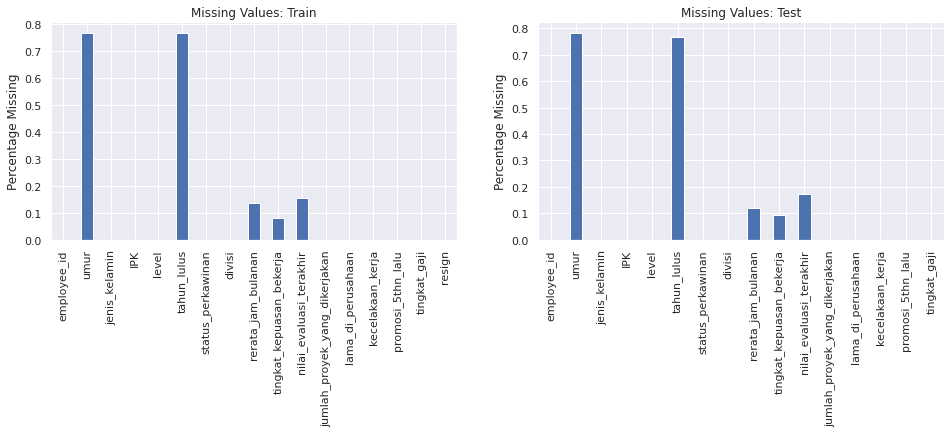

In [24]:
# Missing Values
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

sns.color_palette("mako", as_cmap=True)
(train.isna().sum()/train.shape[0]).plot(kind='bar', ax=ax1)
ax1.set_title('Missing Values: Train')
ax1.set_ylabel('Percentage Missing')

(test.isna().sum()/test.shape[0]).plot(kind='bar', ax=ax2)
ax2.set_title('Missing Values: Test')
ax2.set_ylabel('Percentage Missing')

## Distribution of Responses on Columns

<AxesSubplot:xlabel='nilai_evaluasi_terakhir', ylabel='Density'>

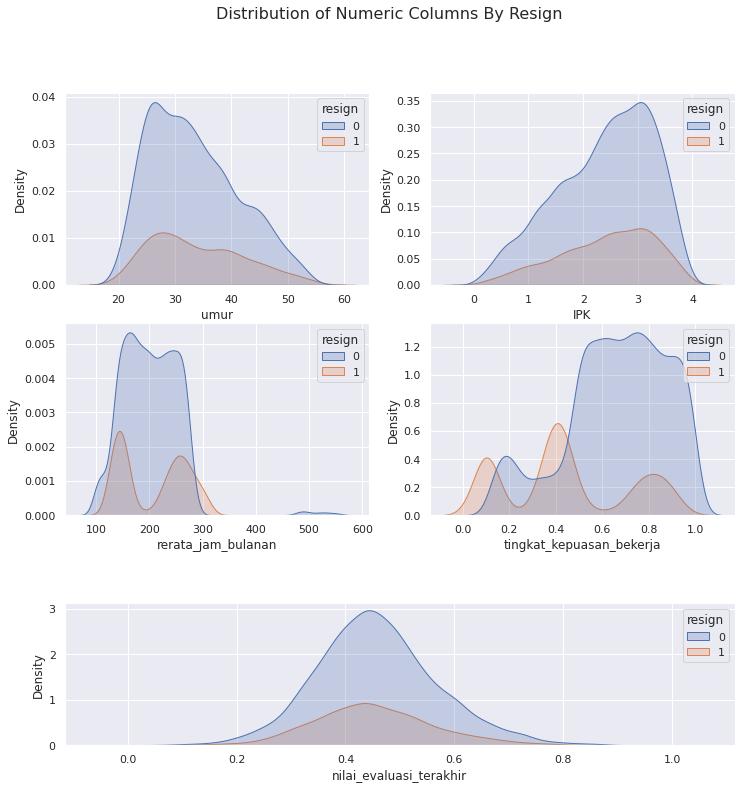

In [25]:
# Distribution of Numeric Columns By Response
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2,figsize=(12,12))

ax5.remove()
ax6.remove()

ax5 = fig.add_subplot(414)

fig.suptitle('Distribution of Numeric Columns By Resign', fontsize=16)

sns.kdeplot(ax=ax1, x='umur', hue='resign', data=train, shade=True)
sns.kdeplot(ax=ax2, x='IPK', hue='resign', data=train, shade=True)
sns.kdeplot(ax=ax3, x='rerata_jam_bulanan', hue='resign', data=train, shade=True)
sns.kdeplot(ax=ax4, x='tingkat_kepuasan_bekerja', hue='resign', data=train, shade=True)
sns.kdeplot(ax=ax5, x='nilai_evaluasi_terakhir', hue='resign', data=train, shade=True)

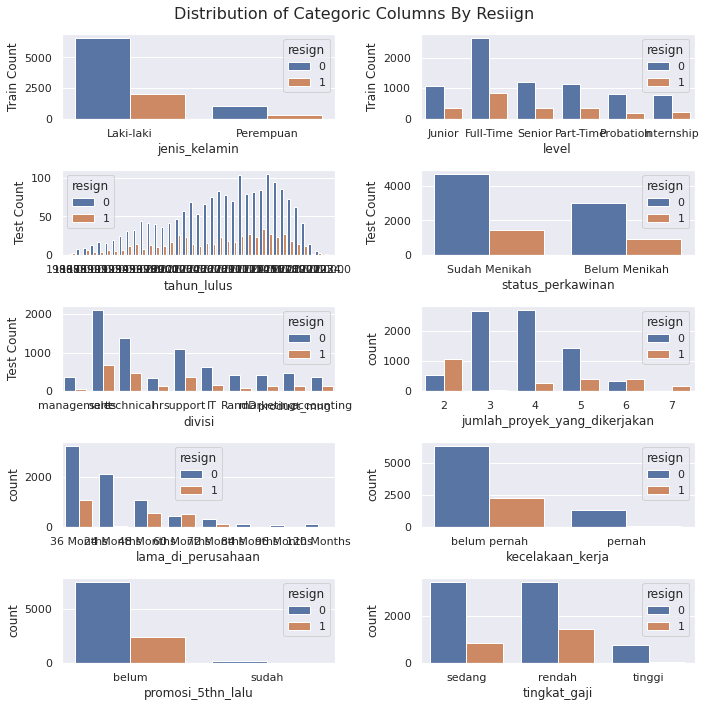

In [26]:
# Distribution of Pelanggan_Sejak_Bulan & Pembatalan_Sebulan_Terakhir Columns By Target
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2,figsize=(10,10))
#ax7.remove()
#ax8.remove()

#ax7 = fig.add_subplot(414)

fig.suptitle('Distribution of Categoric Columns By Resiign', fontsize=16)
      
sns.countplot(ax=ax1, x='jenis_kelamin', hue='resign', data=train)
sns.countplot(ax=ax2, x='level', hue='resign', data=train)
sns.countplot(ax=ax3, x='tahun_lulus', hue='resign', data=train)
sns.countplot(ax=ax4, x='status_perkawinan', hue='resign', data=train)
sns.countplot(ax=ax5, x='divisi', hue='resign', data=train)
sns.countplot(ax=ax6, x='jumlah_proyek_yang_dikerjakan', hue='resign', data=train)
sns.countplot(ax=ax7, x='lama_di_perusahaan', hue='resign', data=train)
sns.countplot(ax=ax8, x='kecelakaan_kerja', hue='resign', data=train)
sns.countplot(ax=ax9, x='promosi_5thn_lalu', hue='resign', data=train)
sns.countplot(ax=ax10, x='tingkat_gaji', hue='resign', data=train)

ax1.set_ylabel('Train Count')
ax2.set_ylabel('Train Count')
ax3.set_ylabel('Test Count')
ax4.set_ylabel('Test Count')
ax5.set_ylabel('Test Count')

#ax7.tick_params(rotation=90)
fig.tight_layout()

Text(0.5, 1.0, 'Heatmap')

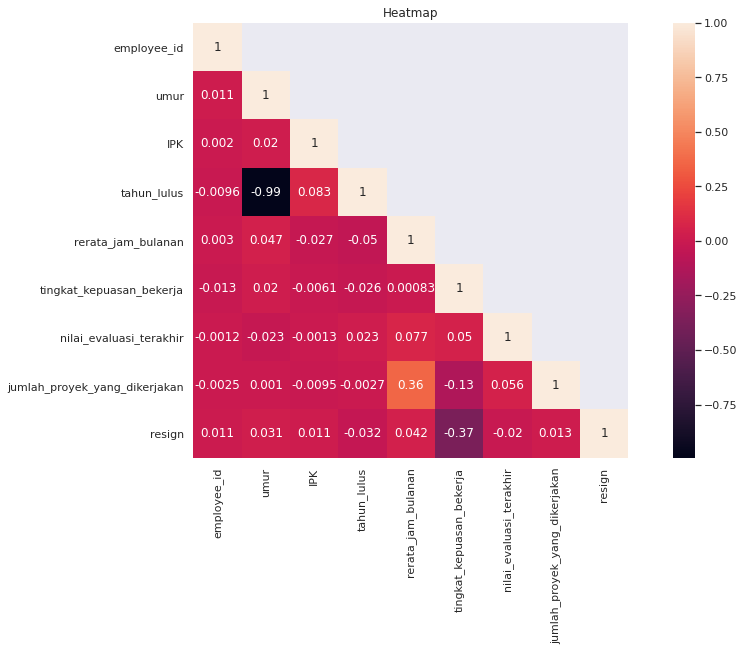

In [27]:
# Plot Data Correlations
fig, ax1 = plt.subplots(1, 1, figsize=(16,8))

#
mask = np.array(train.corr())
mask[np.tril_indices_from(mask)] = False


sns.heatmap(train.corr(), mask=mask, ax=ax1, annot=True, square=True)
ax1.set_title('Heatmap')

# Data Preprocessing

In [28]:
train = train.dropna(subset=['rerata_jam_bulanan', 'tingkat_kepuasan_bekerja', 'nilai_evaluasi_terakhir'])
test = test.dropna(subset=['rerata_jam_bulanan', 'tingkat_kepuasan_bekerja', 'nilai_evaluasi_terakhir'])

In [29]:
# Create copy of train & test data for preprocessing
train_pp = train.copy()
test_pp = test.copy()

In [30]:
train_pp = train_pp.drop(['employee_id', 'umur', 'tahun_lulus'], axis=1)
test_pp = test_pp.drop(['employee_id', 'umur', 'tahun_lulus'], axis=1)

In [31]:
train_pp.head()

,jenis_kelamin,IPK,level,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji,resign
0,Laki-laki,1.947303,Junior,Sudah Menikah,management,210.0,0.82,0.419035,3,36 Months,belum pernah,belum,sedang,0
1,Laki-laki,3.218346,Full-Time,Belum Menikah,sales,189.0,0.76,0.558254,3,24 Months,belum pernah,belum,rendah,0
3,Laki-laki,3.178748,Full-Time,Belum Menikah,sales,121.0,0.84,0.446109,3,36 Months,pernah,belum,rendah,0
5,Laki-laki,1.801649,Junior,Belum Menikah,sales,272.0,0.10,0.569473,5,48 Months,belum pernah,belum,sedang,1
6,Perempuan,1.159184,Probation,Belum Menikah,technical,153.0,0.97,0.493336,3,24 Months,belum pernah,belum,rendah,0


## Drop "employee_id" columns

In [32]:
# Delete useless columns
#train_pp = train_pp.drop(['employee_id', 'umur', 'tahun_lulus'], axis=1)
#test_pp = test_pp.drop(['employee_id', 'umur', 'tahun_lulus'], axis=1)

In [33]:
#train_pp_dropped = train_pp.dropna(subset=['rerata_jam_bulanan', 'tingkat_kepuasan_bekerja', 'nilai_evaluasi_terakhir'])
#test_pp_dropped = test_pp.dropna(subset=['rerata_jam_bulanan', 'tingkat_kepuasan_bekerja', 'nilai_evaluasi_terakhir'])

In [34]:
train_pp.head()

,jenis_kelamin,IPK,level,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji,resign
0,Laki-laki,1.947303,Junior,Sudah Menikah,management,210.0,0.82,0.419035,3,36 Months,belum pernah,belum,sedang,0
1,Laki-laki,3.218346,Full-Time,Belum Menikah,sales,189.0,0.76,0.558254,3,24 Months,belum pernah,belum,rendah,0
3,Laki-laki,3.178748,Full-Time,Belum Menikah,sales,121.0,0.84,0.446109,3,36 Months,pernah,belum,rendah,0
5,Laki-laki,1.801649,Junior,Belum Menikah,sales,272.0,0.10,0.569473,5,48 Months,belum pernah,belum,sedang,1
6,Perempuan,1.159184,Probation,Belum Menikah,technical,153.0,0.97,0.493336,3,24 Months,belum pernah,belum,rendah,0


## Impute missing values

### For Data Train

In [35]:
# Initialize SimpleImputer class
#umur = SimpleImputer(strategy='most_frequent')

In [36]:
# Fill missing values in 'umur' column
#train_pp['umur'] = umur.fit_transform(train_pp['umur'].values.reshape(-1,1))

In [37]:
# Initialize SimpleImputer class
#thlulus_imputer = SimpleImputer(strategy='most_frequent')

In [38]:
# Fill missing values in 'tahun_lulus' column
#train_pp['tahun_lulus'] = thlulus_imputer.fit_transform(train_pp['tahun_lulus'].values.reshape(-1,1))

In [39]:
# Initialize SimpleImputer class
jambln_imputer = SimpleImputer(strategy='most_frequent')

In [40]:
# Fill missing values in 'rerata_jam_bulanan' column
train_pp['rerata_jam_bulanan'] = jambln_imputer.fit_transform(train_pp['rerata_jam_bulanan'].values.reshape(-1,1))

In [41]:
# Initialize SimpleImputer class
kepuasan_imputer = SimpleImputer(strategy='mean')

In [42]:
# Fill missing values in 'tingkat_kepuasan_bekerja' column
train_pp['tingkat_kepuasan_bekerja'] = kepuasan_imputer.fit_transform(train_pp['tingkat_kepuasan_bekerja'].values.reshape(-1,1))

In [43]:
# Initialize SimpleImputer class
nilaiev_imputer = SimpleImputer(strategy='most_frequent')

In [44]:
# Fill missing values in 'nilai_evaluasi_terakhir' column
train_pp['nilai_evaluasi_terakhir'] = nilaiev_imputer.fit_transform(train_pp['nilai_evaluasi_terakhir'].values.reshape(-1,1))

In [45]:
# Check whether missing values are filled
train_pp.isna().sum()

jenis_kelamin                    0
IPK                              0
level                            0
status_perkawinan                0
divisi                           0
rerata_jam_bulanan               0
tingkat_kepuasan_bekerja         0
nilai_evaluasi_terakhir          0
jumlah_proyek_yang_dikerjakan    0
lama_di_perusahaan               0
kecelakaan_kerja                 0
promosi_5thn_lalu                0
tingkat_gaji                     0
resign                           0
dtype: int64

### For Data Test

In [46]:
# Initialize SimpleImputer class
#t_umur_imputer = SimpleImputer(strategy='most_frequent')

In [47]:
# Fill missing values in 'umur' column
#test_pp['umur'] = t_umur_imputer.fit_transform(test_pp['umur'].values.reshape(-1,1))

In [48]:
# Initialize SimpleImputer class
#t_thlulus_imputer = SimpleImputer(strategy='most_frequent')

In [49]:
# Fill missing values in 'tahun_lulus' column
#test_pp['tahun_lulus'] = t_thlulus_imputer.fit_transform(test_pp['tahun_lulus'].values.reshape(-1,1))

In [50]:
# Initialize SimpleImputer class
t_jambln_imputer = SimpleImputer(strategy='most_frequent')

In [51]:
# Fill missing values in 'rerata_jam_bulanan' column
test_pp['rerata_jam_bulanan'] = t_jambln_imputer.fit_transform(test_pp['rerata_jam_bulanan'].values.reshape(-1,1))

In [52]:
# Initialize SimpleImputer class
t_kepuasan_imputer = SimpleImputer(strategy='mean')

In [53]:
# Fill missing values in 'tingkat_kepuasan_bekerja' column
test_pp['tingkat_kepuasan_bekerja'] = t_kepuasan_imputer.fit_transform(test_pp['tingkat_kepuasan_bekerja'].values.reshape(-1,1))

In [54]:
# Initialize SimpleImputer class
t_nilaiev_imputer = SimpleImputer(strategy='most_frequent')

In [55]:
# Fill missing values in 'nilai_evaluasi_terakhir' column
test_pp['nilai_evaluasi_terakhir'] = t_nilaiev_imputer.fit_transform(test_pp['nilai_evaluasi_terakhir'].values.reshape(-1,1))

In [56]:
# Check whether missing values are filled
test_pp.isna().sum()

jenis_kelamin                    0
IPK                              0
level                            0
status_perkawinan                0
divisi                           0
rerata_jam_bulanan               0
tingkat_kepuasan_bekerja         0
nilai_evaluasi_terakhir          0
jumlah_proyek_yang_dikerjakan    0
lama_di_perusahaan               0
kecelakaan_kerja                 0
promosi_5thn_lalu                0
tingkat_gaji                     0
dtype: int64

## Encoding categorical variables

### For Data Train

In [57]:
train_pp.dtypes

jenis_kelamin                     object
IPK                              float64
level                             object
status_perkawinan                 object
divisi                            object
rerata_jam_bulanan               float64
tingkat_kepuasan_bekerja         float64
nilai_evaluasi_terakhir          float64
jumlah_proyek_yang_dikerjakan      int64
lama_di_perusahaan                object
kecelakaan_kerja                  object
promosi_5thn_lalu                 object
tingkat_gaji                      object
resign                             int64
dtype: object

In [58]:
train_pp['lama_di_perusahaan']=  train_pp['lama_di_perusahaan'].str.replace("Years", '*12').str.replace('Months','*1').apply(eval).astype(str) + ' Months'

In [59]:
categorical_cols = ['jenis_kelamin', 'level', 'tahun_lulus', 'status_perkawinan', 'divisi', 'jumlah_proyek_yang_dikerjakan', 'lama_di_perusahaan', 'kecelakaan_kerja', 'promosi_5thn_lalu', 'tingkat_gaji']
categorical_cols

['jenis_kelamin',
 'level',
 'tahun_lulus',
 'status_perkawinan',
 'divisi',
 'jumlah_proyek_yang_dikerjakan',
 'lama_di_perusahaan',
 'kecelakaan_kerja',
 'promosi_5thn_lalu',
 'tingkat_gaji']

In [60]:
train_pp.head()

,jenis_kelamin,IPK,level,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji,resign
0,Laki-laki,1.947303,Junior,Sudah Menikah,management,210.0,0.82,0.419035,3,36 Months,belum pernah,belum,sedang,0
1,Laki-laki,3.218346,Full-Time,Belum Menikah,sales,189.0,0.76,0.558254,3,24 Months,belum pernah,belum,rendah,0
3,Laki-laki,3.178748,Full-Time,Belum Menikah,sales,121.0,0.84,0.446109,3,36 Months,pernah,belum,rendah,0
5,Laki-laki,1.801649,Junior,Belum Menikah,sales,272.0,0.10,0.569473,5,48 Months,belum pernah,belum,sedang,1
6,Perempuan,1.159184,Probation,Belum Menikah,technical,153.0,0.97,0.493336,3,24 Months,belum pernah,belum,rendah,0


### For Data Test

In [61]:
test_pp.dtypes

jenis_kelamin                     object
IPK                              float64
level                             object
status_perkawinan                 object
divisi                            object
rerata_jam_bulanan               float64
tingkat_kepuasan_bekerja         float64
nilai_evaluasi_terakhir          float64
jumlah_proyek_yang_dikerjakan      int64
lama_di_perusahaan                object
kecelakaan_kerja                  object
promosi_5thn_lalu                 object
tingkat_gaji                      object
dtype: object

In [62]:
test_pp.head()

,jenis_kelamin,IPK,level,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji
0,Laki-laki,2.119406,Senior,Belum Menikah,technical,137.0,0.38,0.372242,2,36 Months,belum pernah,belum,rendah
1,Laki-laki,2.554876,Part-Time,Sudah Menikah,sales,258.0,0.85,0.334727,3,3 Years,belum pernah,belum,sedang
2,Laki-laki,1.151644,Probation,Sudah Menikah,marketing,257.0,0.91,0.459594,3,36 Months,belum pernah,belum,sedang
3,Perempuan,1.963498,Senior,Belum Menikah,sales,142.0,0.42,0.370912,2,3 Years,belum pernah,belum,rendah
4,Perempuan,1.666068,Junior,Belum Menikah,sales,272.0,0.93,0.563354,3,2 Years,pernah,belum,rendah


In [63]:
test_pp['lama_di_perusahaan']=  test_pp['lama_di_perusahaan'].str.replace("Years", '*12').str.replace('Months','*1').apply(eval).astype(str) + ' Months'

In [64]:
test_pp.head()

,jenis_kelamin,IPK,level,status_perkawinan,divisi,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,lama_di_perusahaan,kecelakaan_kerja,promosi_5thn_lalu,tingkat_gaji
0,Laki-laki,2.119406,Senior,Belum Menikah,technical,137.0,0.38,0.372242,2,36 Months,belum pernah,belum,rendah
1,Laki-laki,2.554876,Part-Time,Sudah Menikah,sales,258.0,0.85,0.334727,3,36 Months,belum pernah,belum,sedang
2,Laki-laki,1.151644,Probation,Sudah Menikah,marketing,257.0,0.91,0.459594,3,36 Months,belum pernah,belum,sedang
3,Perempuan,1.963498,Senior,Belum Menikah,sales,142.0,0.42,0.370912,2,36 Months,belum pernah,belum,rendah
4,Perempuan,1.666068,Junior,Belum Menikah,sales,272.0,0.93,0.563354,3,24 Months,pernah,belum,rendah


In [65]:
categorical_cols = ['jenis_kelamin', 'level', 'tahun_lulus', 'status_perkawinan', 'divisi', 'jumlah_proyek_yang_dikerjakan', 'lama_di_perusahaan', 'kecelakaan_kerja', 'promosi_5thn_lalu', 'tingkat_gaji']
categorical_cols

['jenis_kelamin',
 'level',
 'tahun_lulus',
 'status_perkawinan',
 'divisi',
 'jumlah_proyek_yang_dikerjakan',
 'lama_di_perusahaan',
 'kecelakaan_kerja',
 'promosi_5thn_lalu',
 'tingkat_gaji']

In [66]:
# Encode object-type columns
train_pp = pd.get_dummies(train_pp, drop_first=True)
test_pp = pd.get_dummies(test_pp, drop_first=True)

In [67]:
train_pp.head()

,IPK,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,resign,jenis_kelamin_Perempuan,level_Internship,level_Junior,level_Part-Time,...,lama_di_perusahaan_36 Months,lama_di_perusahaan_48 Months,lama_di_perusahaan_60 Months,lama_di_perusahaan_72 Months,lama_di_perusahaan_84 Months,lama_di_perusahaan_96 Months,kecelakaan_kerja_pernah,promosi_5thn_lalu_sudah,tingkat_gaji_sedang,tingkat_gaji_tinggi
0,1.947303,210.0,0.82,0.419035,3,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,3.218346,189.0,0.76,0.558254,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.178748,121.0,0.84,0.446109,3,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5,1.801649,272.0,0.10,0.569473,5,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
6,1.159184,153.0,0.97,0.493336,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
test_pp.head()

,IPK,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,jenis_kelamin_Perempuan,level_Internship,level_Junior,level_Part-Time,level_Probation,...,lama_di_perusahaan_36 Months,lama_di_perusahaan_48 Months,lama_di_perusahaan_60 Months,lama_di_perusahaan_72 Months,lama_di_perusahaan_84 Months,lama_di_perusahaan_96 Months,kecelakaan_kerja_pernah,promosi_5thn_lalu_sudah,tingkat_gaji_sedang,tingkat_gaji_tinggi
0,2.119406,137.0,0.38,0.372242,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2.554876,258.0,0.85,0.334727,3,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,1.151644,257.0,0.91,0.459594,3,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,1.963498,142.0,0.42,0.370912,2,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.666068,272.0,0.93,0.563354,3,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


# Modelling & Evaluation

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [70]:
# splitting into train and validation set
# cross-validation could also be used if the dataset is limited
train_x, val_x, train_y, val_y = train_test_split(train_pp.drop(columns='resign'), train_pp['resign'], test_size=0.2, random_state=69)

In [71]:
train_x.head()

,IPK,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,jenis_kelamin_Perempuan,level_Internship,level_Junior,level_Part-Time,level_Probation,...,lama_di_perusahaan_36 Months,lama_di_perusahaan_48 Months,lama_di_perusahaan_60 Months,lama_di_perusahaan_72 Months,lama_di_perusahaan_84 Months,lama_di_perusahaan_96 Months,kecelakaan_kerja_pernah,promosi_5thn_lalu_sudah,tingkat_gaji_sedang,tingkat_gaji_tinggi
4806,2.171005,134.0,0.38,0.355632,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8031,2.505726,248.0,0.96,0.601369,5,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3288,3.369669,179.0,0.24,0.460079,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
7758,2.353441,273.0,0.11,0.501701,7,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7679,3.186481,267.0,0.78,0.528791,4,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [72]:
val_x.head()

,IPK,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,jenis_kelamin_Perempuan,level_Internship,level_Junior,level_Part-Time,level_Probation,...,lama_di_perusahaan_36 Months,lama_di_perusahaan_48 Months,lama_di_perusahaan_60 Months,lama_di_perusahaan_72 Months,lama_di_perusahaan_84 Months,lama_di_perusahaan_96 Months,kecelakaan_kerja_pernah,promosi_5thn_lalu_sudah,tingkat_gaji_sedang,tingkat_gaji_tinggi
7856,3.161603,250.0,0.91,0.580028,4,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1383,2.584766,260.0,0.10,0.684476,6,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
5803,0.743758,479.0,0.98,0.317661,3,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
7688,2.692158,191.0,0.60,0.544716,5,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4686,3.313499,205.0,0.59,0.553241,4,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [73]:
rf = RandomForestClassifier(random_state=0)
rf.fit(train_x, train_y)
pred = rf.predict(val_x)

print('Classification report model')
print(classification_report(val_y, pred, digits=5))

Classification report model
              precision    recall  f1-score   support

           0    0.97736   0.99424   0.98573      1042
           1    0.97966   0.92332   0.95066       313

    accuracy                        0.97786      1355
   macro avg    0.97851   0.95878   0.96819      1355
weighted avg    0.97789   0.97786   0.97763      1355



## Feature Importance

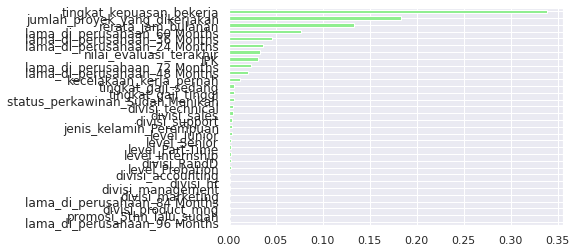

In [74]:
#Feature Importance using RandomForestClassifier
importances_rf = pd.Series(rf.feature_importances_, index=val_x.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen')
plt.rcParams["figure.figsize"] = (6,20)
plt.yticks(fontsize=12)
plt.show()

# Predicting the Model

In [75]:
test_pp.head()

,IPK,rerata_jam_bulanan,tingkat_kepuasan_bekerja,nilai_evaluasi_terakhir,jumlah_proyek_yang_dikerjakan,jenis_kelamin_Perempuan,level_Internship,level_Junior,level_Part-Time,level_Probation,...,lama_di_perusahaan_36 Months,lama_di_perusahaan_48 Months,lama_di_perusahaan_60 Months,lama_di_perusahaan_72 Months,lama_di_perusahaan_84 Months,lama_di_perusahaan_96 Months,kecelakaan_kerja_pernah,promosi_5thn_lalu_sudah,tingkat_gaji_sedang,tingkat_gaji_tinggi
0,2.119406,137.0,0.38,0.372242,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2.554876,258.0,0.85,0.334727,3,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,1.151644,257.0,0.91,0.459594,3,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,1.963498,142.0,0.42,0.370912,2,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.666068,272.0,0.93,0.563354,3,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [76]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(train_x, train_y)
prediction = rf.predict(test_pp)

output = pd.DataFrame()
output['employee_id'] = test['employee_id']
output['resign'] = prediction
output.head()

,employee_id,resign
0,20049,1
1,20050,0
2,20051,0
3,20052,1
4,20053,0


In [77]:
#convert the output 'resign' column datatype to integer, kalo belum integer aja
#output['resign'] = output['resign].astype(int)
#print('already converted 'resign' column to integer')

In [78]:
#cek dulu the length of test and output dataframe
if len(output) == len(test):
  print('dataframe length output dan length test udah sama')
else:
  print('dataframe nya mismatched. gabisa submit')

dataframe length output dan length test udah sama


In [79]:
#masukkin hasil ke format csv
output.to_csv('submission_tim_hore.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [80]:
#cek file hasil
#baca = pd.read_csv('submission_tim_hore.csv')
#baca.head()